# Deep Learning - Underwater object detection - UODD

In this notebook file there will be a focus on the UODD dataset.


In [1]:
# Import of used libraries

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

## Part I - Image Pre-processing

The first pre-processing test will be with the Underwater Object Detection Dataset (UODD).

In [6]:
# Load the images
uodd_pic_path = 'Datasets/Underwater-object-detection-dataset/imgs/test'

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(str(os.path.join(folder, filename)))
        if img is not None:
            images.append(img)
    return images

loaded_images = load_images_from_folder(uodd_pic_path)
print(f"[UODD] Loaded {len(loaded_images)} images.")

[UODD] Loaded 506 images.


In [7]:
# Enhance the image by improving its visibility using histogram equalization.
def enhance_image(image):
    # Convert to YUV color space
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # Equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # Convert back to BGR color space
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_output

# Reduce noise in the image using Gaussian Blur.
def reduce_noise(image):
    # Apply Gaussian Blur
    img_output = cv2.GaussianBlur(image, (5, 5), 0)
    return img_output

# Correct the color of the image using CLAHE (Contrast Limited Adaptive Histogram Equalization).
def correct_color(image):
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # Split the channels
    l, a, b = cv2.split(lab)
    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    # Merge channels back
    lab = cv2.merge((l, a, b))
    # Convert back to BGR color space
    img_output = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return img_output

In [8]:
# Step 2 - Pre-process the images

def preprocess_image(image):
    # Apply enhancement
    enhanced_img = enhance_image(image)
    # Apply noise reduction
    noise_reduced_img = reduce_noise(enhanced_img)
    # Apply color correction
    corrected_img = correct_color(noise_reduced_img)
    return corrected_img

# Pre-process all images
preprocessed_images = [preprocess_image(img) for img in images]

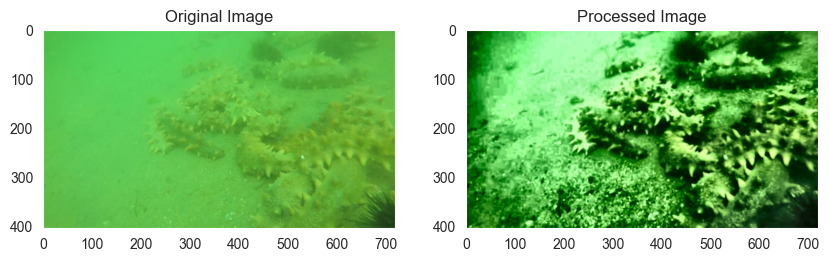

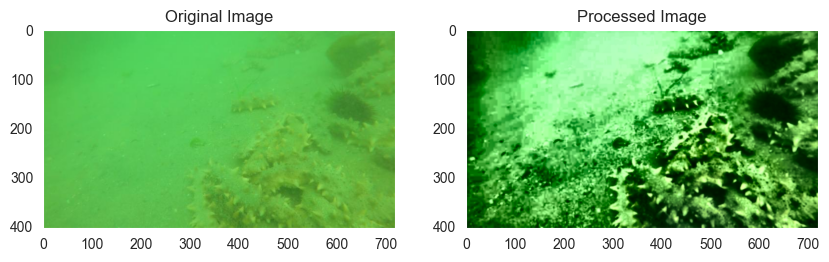

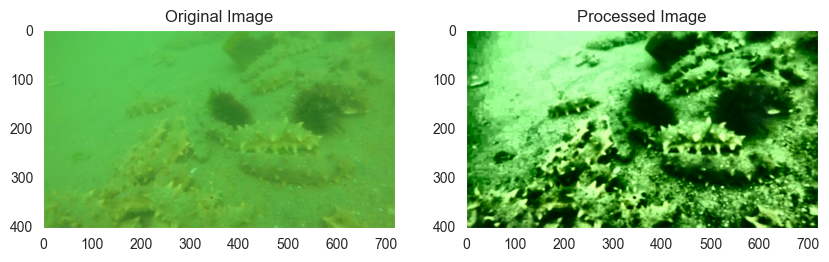

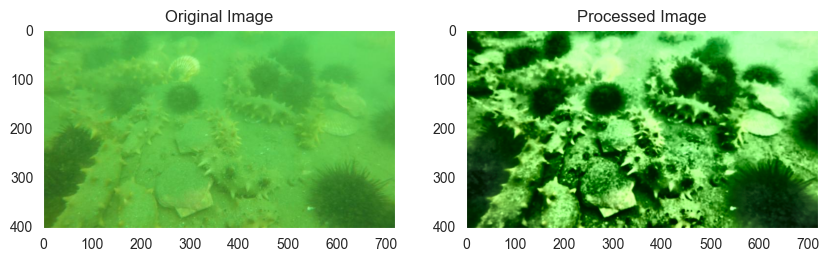

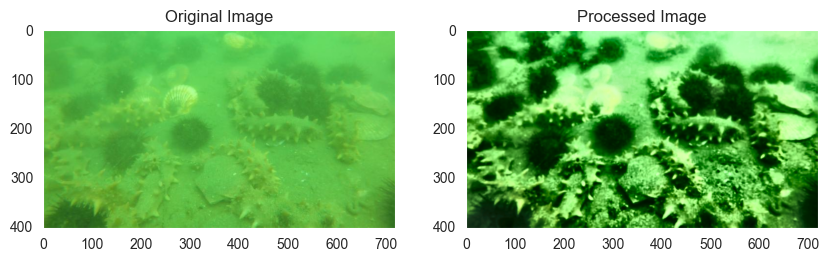

In [15]:
# Step 3 - Display the pre-processed images
def display_images(original, processed, index):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.grid(None)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.grid(None)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    plt.title('Processed Image')
    plt.show()

# Display the first 5 images for comparison
for i in range(5):
    display_images(images[i], preprocessed_images[i], i)

## Part II - Detection with CNN model (YOLOvX)

This part focuses on training a YOLO model to detect objects in the UODD dataset.

In [21]:
from os.path import isfile, join
from os import listdir

# Preparation of the dataset for YOLO_UODD
uodd_pics_train_path = 'Datasets/Underwater-object-detection-dataset/imgs/train'
uodd_labels_train_path = 'Datasets/Underwater-object-detection-dataset/labels/train'
uodd_pics_val_path = 'Datasets/Underwater-object-detection-dataset/imgs/val'
uodd_labels_val_path = 'Datasets/Underwater-object-detection-dataset/labels/val'

train_images = [preprocess_image(img) for img in load_images_from_folder(uodd_pics_train_path)]
train_filenames = [f for f in listdir(uodd_pics_train_path) if isfile(join(uodd_pics_train_path, f))]
train_filenames = [f.split('.')[0] for f in train_filenames]
val_images = [preprocess_image(img) for img in load_images_from_folder(uodd_pics_val_path)]
val_filenames = [f for f in listdir(uodd_pics_val_path) if isfile(join(uodd_pics_val_path, f))]
val_filenames = [f.split('.')[0] for f in val_filenames]

base_path = './Datasets/YOLO_UODD'
train_images_path = os.path.join(base_path, 'images/train')
val_images_path = os.path.join(base_path, 'images/val')
train_labels_path = os.path.join(base_path, 'labels/train')
val_labels_path = os.path.join(base_path, 'labels/val')

# Create directories if they don't exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(val_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(val_labels_path, exist_ok=True)

# Pre-Processing for training set
for i, img in enumerate(train_images):
    img_name = f'{train_filenames[i]}.jpg'

    cv2.imwrite(str(os.path.join(train_images_path, img_name)), img)
    shutil.copy(os.path.join(uodd_labels_train_path, f'{train_filenames[i]}.txt'), train_labels_path)

# Pre-Processing for validation set
for i, img in enumerate(val_images):
    img_name = f'{val_filenames[i]}.jpg'
    cv2.imwrite(str(os.path.join(val_images_path, img_name)), img)
    shutil.copy(os.path.join(uodd_labels_val_path, f'{val_filenames[i]}.txt'), val_labels_path)

In [1]:
# STEP 2 - Load the YOLO model and commence training
from ultralytics import YOLO

# preparation of the YOLO model
model = YOLO("yolov5n.pt")  # load a pretrained model (recommended for training)
results = model.train(data="uodd.yaml", epochs=3, batch=3)

PRO TIP  Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 5.27M/5.27M [00:00<00:00, 22.7MB/s]


Ultralytics YOLOv8.2.31  Python-3.11.9 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=uodd.yaml, epochs=3, time=None, patience=100, batch=3, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

train: Scanning C:\Users\tommc\Desktop\AUT - Courses\Deep Learning - DL\aut-deep-leaning\project\Python\Datasets\YOLO_UODD\labels\train.cache... 2560 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2560/2560 [00:00<?, ?it/s]
val: Scanning C:\Users\tommc\Desktop\AUT - Courses\Deep Learning - DL\aut-deep-leaning\project\Python\Datasets\YOLO_UODD\labels\val.cache... 128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0004921875), 75 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train10
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3     0.711G      1.983      4.252      1.413         30        640:   0%|          | 1/854 [00:05<1:18:52,  5.55s/it]


RuntimeError: DataLoader worker (pid(s) 12088, 17632, 37348, 32840, 17460, 30456, 34408) exited unexpectedly